In [22]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.6.0
device: cpu


This is the MNIST dataset with labels 3 and 4.
Imbalanced Ratio:  0.1
Number of label 3 in the final training set:  6131
Number of label 4 in the final training set (after downsampling):  613
Number of label 3 in the final test set:  1010
Number of label 4 in the final test set:  982
Total samples in final training set:  6744
Total samples in final test set:  1992
Number of batches in training set:  106
Number of batches in test set:  32
Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])
First image tensor:
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

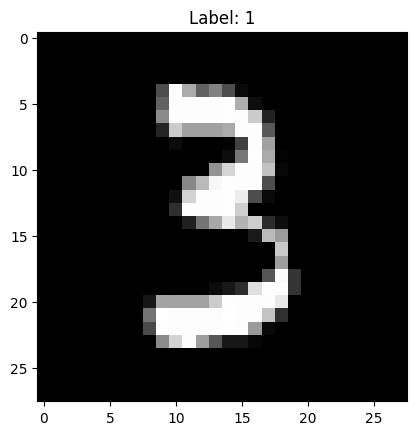

X_train.shape: (6744, 784)
y_train.shape: (6744,)
X_test.shape: (1992, 784)
y_test.shape: (1992,)


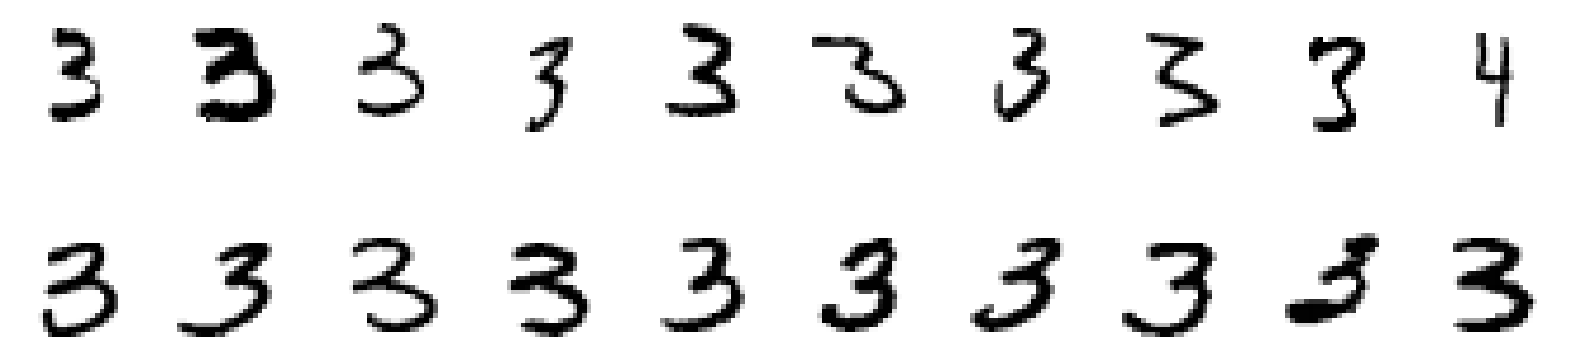

In [ ]:
# Data
from Get_datasets import get_datasets
X_train, y_train, X_test, y_test, train_loader, test_loader = get_datasets(dataname="mnist34",fraction=0.1)
# Hyperparameters
img_size = 28 # Image size
latent_size = 300 # Latent vector size
batch_size = 64  # Batch size
# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]
# Training
epochs = 100  # Train epochs
learning_rate = 1e-4

In [25]:
print(train_loader)
print(test_loader)

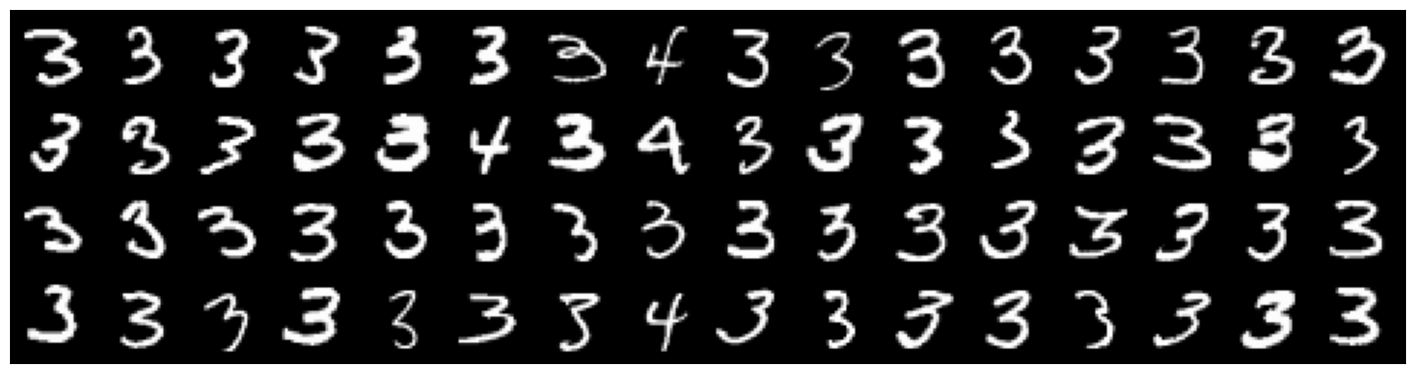

In [26]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

In [27]:
import collections  # 导入collections模块，用于统计和操作容器数据，如Counter
import torch  # 导入PyTorch库，用于深度学习任务
import torch.nn as nn  # 从torch中导入神经网络模块，简化模型构建
from torch.utils.data import TensorDataset  # 导入TensorDataset，用于将Tensor数据打包成数据集
import numpy as np  # 导入NumPy库，用于高效的数值计算和数组操作
from sklearn.neighbors import NearestNeighbors  # 导入最近邻算法，用于在SMOTE中寻找相邻样本
import time  # 导入time模块，用于计时
import os  # 导入os模块，用于文件和目录操作
print(torch.version.cuda)  # 打印当前PyTorch使用的CUDA版本，例如显示"10.1"

t3 = time.time()  # 记录程序开始时的时间，用于后续计算总运行时间
##############################################################################
"""args for AE"""
# 以下部分设置自动编码器（AE）的相关参数
args = {}  # 创建一个空字典，用于存放模型和训练的参数
args['dim_h'] = 64         # 设置隐藏层通道数的基础因子，后续卷积层的通道数会成倍增加
args['n_channel'] = 1  #3    # 输入数据的通道数，1表示灰度图（3则为彩色图）；这里选用灰度图
args['n_z'] = 300 #600     # 潜在空间（编码空间）的维度数，决定编码器输出特征向量的大小
args['sigma'] = 1.0        # 潜在空间中使用的方差参数，可用于正则化
args['lambda'] = 0.01      # 判别器损失的权重超参数（如在对抗训练中使用）
args['lr'] = 0.0002        # Adam优化器的学习率，决定参数更新的步长
args['epochs'] = 50       # 训练过程中遍历数据集的轮数
args['batch_size'] = 64   # 每个训练批次的样本数量
args['save'] = True        # 如果为True，则在每个训练轮结束时保存模型权重
args['train'] = True       # 若为True则进行训练，否则加载已保存的模型进行测试
args['dataset'] = 'mnist34'  #'fmnist' # 指定使用的数据集，这里选择MNIST数据集 mnist34 mnist17 fashionmnist34 cifar10
args['fraction'] = 0.005   # 用于训练的数据集的子集比例，可用于快速测试

##############################################################################
print(args)

import torch.nn.functional as F
# Attention Block
class AttentionBlock(nn.Module):
    def __init__(self, filters):
        """
        :param filters: 输入特征图的通道数(同时也是卷积输出的通道数)
        """
        super(AttentionBlock, self).__init__()
        # 与 Keras 中的 Conv2D(filters, kernel_size=1, padding='same') 对应
        # PyTorch 中 padding=0 就相当于 'same'（仅当 kernel_size=1 时）
        self.query_conv = nn.Conv2d(filters, filters, kernel_size=1, padding=0)
        self.key_conv   = nn.Conv2d(filters, filters, kernel_size=1, padding=0)
        self.value_conv = nn.Conv2d(filters, filters, kernel_size=1, padding=0)

    def forward(self, x):
        """
        x 的形状一般是 (batch_size, filters, H, W)
        """
        # 1. 分别得到 query, key, value
        query = F.relu(self.query_conv(x))
        key   = F.relu(self.key_conv(x))
        value = F.relu(self.value_conv(x))

        # 2. 计算注意力图: 先元素乘，再对通道维度 (dim=1) 求和
        attention_map = query * key                  # 形状 (N, filters, H, W)
        attention_map = torch.sum(attention_map, dim=1, keepdim=True)  
        # 现在 attention_map 的形状是 (N, 1, H, W)

        # 3. 对空间维度 (H, W) 做 softmax
        # 先展平再 softmax，再 reshape 回去
        N, _, H, W = attention_map.shape
        attention_map = attention_map.view(N, 1, -1)         # (N, 1, H*W)
        attention_map = F.softmax(attention_map, dim=-1)     # 在 H*W 上做 softmax
        attention_map = attention_map.view(N, 1, H, W)       # (N, 1, H, W)

        # 4. 注意力加权 value，并与原输入相加
        attended_value = attention_map * value
        output = x + attended_value

        return output
# 定义编码器模型
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()  # 调用父类构造函数
        self.n_channel = args['n_channel']  # 获取输入数据的通道数
        self.dim_h = args['dim_h']          # 获取隐藏层基本通道数
        self.n_z = args['n_z']              # 获取潜在空间的维度数
        
        # 使用卷积层提取图像特征
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),  
            # 第一层卷积：输入通道数为n_channel，输出为dim_h，卷积核大小4，步幅2，填充1，无偏置
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),  # 使用LeakyReLU激活函数，负半部斜率设为0.2
            AttentionBlock(filters=self.dim_h),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),  
            # 第二层卷积：通道数翻倍到dim_h*2
            nn.BatchNorm2d(self.dim_h * 2),  # 对第二层卷积输出进行批归一化
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),  # 激活函数
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),  
            # 第三层卷积：通道数增加到dim_h*4
            nn.BatchNorm2d(self.dim_h * 4),  # 批归一化
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),  # 激活函数
            
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),  
            # 第四层卷积：通道数增加到dim_h*8
            
            #3d and 32 by 32
            #nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 1, 0, bias=False),  # 备用卷积层配置
            nn.BatchNorm2d(self.dim_h * 8),  # 对第四层卷积输出进行批归一化
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True)  # 激活函数
            # 注释中还有其他可能的卷积配置，这里使用的是标准配置
        )
        # 全连接层：将卷积层输出映射到潜在空间
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)  
        # 这里计算dim_h * (2**3)相当于dim_h*8，假设卷积层最后输出特征数为dim_h*8

    def forward(self, x):
        # 前向传播函数
        # print('enc')  # 调试打印，可查看编码器被调用
        # print('input ', x.size())  # 打印输入尺寸，例如torch.Size([batch_size, channel, H, W])
        x = self.conv(x)  # 将输入图像通过卷积层提取特征
        x = x.squeeze()   # 去除多余的尺寸（例如将[batch_size, 1, N]变为[batch_size, N]）
        # print('aft squeeze ', x.size())  # 调试打印压缩后的尺寸
        x = self.fc(x)    # 通过全连接层映射到潜在空间维度
        # print('out ', x.size())  # 打印最终输出尺寸，应为[batch_size, n_z]
        return x  # 返回编码后的潜在表示

# 定义解码器模型
class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()  # 调用父类构造函数
        self.n_channel = args['n_channel']  # 获取输入通道数（用于输出重构图像）
        self.dim_h = args['dim_h']          # 获取隐藏层基本通道数
        self.n_z = args['n_z']              # 获取潜在空间的维度数

        # 全连接层：将潜在向量映射到足够重构卷积特征图的尺寸
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),  # 将潜在向量转换为高维特征，尺寸为[batch_size, dim_h*8*7*7]
            nn.ReLU()  # 使用ReLU激活函数
        )

        # 反卷积层（转置卷积）：将全连接层的输出转换为图像
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),  
            # 第一层反卷积：将通道数从dim_h*8降到dim_h*4，卷积核大小4
            nn.BatchNorm2d(self.dim_h * 4),  # 批归一化
            nn.ReLU(True),  # 激活函数
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),  
            # 第二层反卷积：将通道数从dim_h*4降到dim_h*2
            nn.BatchNorm2d(self.dim_h * 2),  # 批归一化
            nn.ReLU(True),  # 激活函数
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),  
            # 第三层反卷积：将通道数降为1，同时上采样（步幅为2），恢复到原图大小
            # nn.Sigmoid())  # 也可用Sigmoid激活函数使输出在[0,1]之间
            nn.Tanh()  # 这里使用Tanh激活函数，将输出映射到[-1,1]
        )

    def forward(self, x):
        # 前向传播函数
        # print('dec')  # 调试打印，查看解码器调用
        # print('input ', x.size())  # 打印输入潜在向量的尺寸
        x = self.fc(x)  # 通过全连接层处理潜在向量
        x = x.view(-1, self.dim_h * 8, 7, 7)  
        # 将全连接层输出重塑为特征图，尺寸为[batch_size, dim_h*8, 7, 7]，为反卷积做准备
        x = self.deconv(x)  # 通过反卷积层重构出图像
        return x  # 返回重构图像

None
{'dim_h': 64, 'n_channel': 1, 'n_z': 300, 'sigma': 1.0, 'lambda': 0.01, 'lr': 0.0002, 'epochs': 50, 'batch_size': 64, 'save': True, 'train': True, 'dataset': 'mnist34', 'fraction': 0.005}


In [28]:
train_on_gpu = torch.cuda.is_available()  # 检查是否有可用GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # 指定使用的设备
path_encoder = "/Users/max/MasterThesis/Model/cGAN/DeepSMOTE_0.005_bst_enc.pth"
path_decoder = "/Users/max/MasterThesis/Model/cGAN/DeepSMOTE_0.005_bst_dec.pth"
encoder = Encoder(args) # 创建编码器模型
encoder.load_state_dict(torch.load(path_encoder),strict=False)  # 加载预训练的编码器模型权重
encoder = encoder.to(device)  # 将编码器模型移动到指定设备

decoder = Decoder(args)  # 创建解码器模型
decoder.load_state_dict(torch.load(path_decoder),strict=False)  # 加载预训练的解码器模型权重
decoder = decoder.to(device)  # 将解码器模
encoder.eval()  # 设置编码器为评估模式
decoder.eval()  # 设置解码器为评估模式

# Encoder_X_train = []
# for images,labels in train_loader:
#     images = images.to(device)
#     with torch.no_grad():
#         latent = encoder(images)
#     Encoder_X_train.append(latent.cpu().numpy())
# Encoder_X_train = np.concatenate(Encoder_X_train,axis=0)
# print(Encoder_X_train.shape)

Decoder(
  (fc): Sequential(
    (0): Linear(in_features=300, out_features=25088, bias=True)
    (1): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
    (7): Tanh()
  )
)

In [29]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        
        # Reshape z
        z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([z, c], 1)
        
        # Generator out
        out = self.model(x)
        
        return out.view(-1, self.img_size, self.img_size)

In [30]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        
        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([x, c], 1)
        
        # Discriminator out
        out = self.model(x)
        
        return out.squeeze()

In [31]:
class_num = 2
class_list = [ '3', '4']
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

In [32]:
# Loss function
criterion = nn.BCELoss()

In [33]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [34]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [35]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    # Init gradient 
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)
    
    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # Sum two losses
    d_loss = real_loss + fake_loss
    
    # Backword propagation
    d_loss.backward()
    
    # Optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

In [ ]:
for epoch in range(epochs):
    
    print('Starting epoch {}...'.format(epoch+1))
    
    for i, (images, labels) in enumerate(train_loader):
        
        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        # Set generator train
        generator.train()
        
        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        
        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
    
    # Set generator eval
    generator.eval()
    
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    
    # Building z 
    z = Variable(torch.randn(class_num-1, z_size)).to(device)
    
    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)
    
    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    # Show images
    print(sample_images.shape)
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

Starting epoch 1...


RuntimeError: shape '[-1, 784]' is invalid for input of size 19200

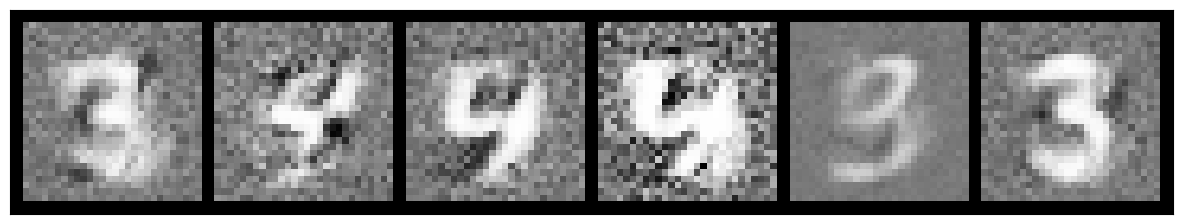

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

z_size = 100  # Adjust based on your model
class_num = 2  # Adjust based on dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 只生成 Class 0 的样本
num_samples = 6 # 生成多少个样本
z = torch.randn(num_samples, z_size).to(device)  # Shape: (num_samples, z_size)
#labels = torch.zeros(num_samples, dtype=torch.long).to(device)  # 全部设为 0 类
labels = torch.tensor([1, 0, 0, 0, 1, 1], dtype=torch.long).to(device)  # 转换为 PyTorch 张量
# Generate images using the generator
sample_images = generator(z, labels).unsqueeze(1).data.cpu()  # Ensure correct batch dimension

# Make image grid
grid = make_grid(sample_images, nrow=num_samples, normalize=True).permute(1, 2, 0).numpy()

# Plot images
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(grid)
ax.set_xticks([])
ax.set_yticks([])
plt.show()